<a href="https://colab.research.google.com/github/nitron-alpha-kplr/Reinforcement-Learning/blob/main/RL_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

#Reinforcement Learning

L'apprentissage par renforcement (RL) est un sous-ensemble de l'apprentissage automatique qui pose les problèmes d'apprentissage comme des interactions entre les agents et les environnements. Il suppose souvent que les agents n'ont aucune connaissance préalable du monde et qu'ils doivent apprendre à naviguer dans les environnements en optimisant une fonction de récompense. Dans un environnement, un agent peut entreprendre certaines actions et recevoir un retour, sous la forme de récompenses positives ou négatives, par rapport à sa décision. En tant que telle, la boucle de rétroaction d'un agent s'apparente quelque peu à l'idée d'"essais et erreurs", ou à la manière dont un enfant peut apprendre à distinguer les "bonnes" et les "mauvaises" actions.

En termes pratiques, notre agent RL interagira avec l'environnement en effectuant une action à chaque pas de temps, en recevant une récompense correspondante et en mettant à jour son état en fonction de ce qu'il a "appris".

![texte alt](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

Bien que l'objectif ultime de l'apprentissage par renforcement soit d'apprendre aux agents à agir dans le monde réel et physique, les environnements simulés - comme les jeux et les moteurs de simulation - constituent un terrain d'essai pratique pour le développement d'algorithmes et d'agents d'apprentissage par renforcement.

Dans les laboratoires précédents, nous avons exploré les tâches d'apprentissage supervisé (avec LSTMs, CNNs) et non supervisé / semi-supervisé (avec VAEs). L'apprentissage par renforcement est fondamentalement différent, dans la mesure où nous formons un algorithme d'apprentissage profond pour régir les actions de notre agent RL, qui essaie, dans son environnement, de trouver la manière optimale d'atteindre un objectif. L'objectif de la formation d'un agent RL est de déterminer la meilleure étape à suivre pour obtenir le meilleur gain ou rendement final. Dans ce laboratoire, nous nous concentrons sur la construction d'un algorithme d'apprentissage par renforcement pour maîtriser deux environnements différents avec une complexité variable.

1.   **Cartpole** :   Équilibrer un poteau, dépassant d'un chariot, dans une position verticale en déplaçant seulement la base à gauche ou à droite. Environnement avec un espace d'observation de faible dimension.



C'est parti ! Tout d'abord, nous allons importer TensorFlow, le paquetage du cours et certaines dépendances.

In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Installing MIT deep learning package... Done


In [3]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:61: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:82: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = np.bool  # pylint: disable=redefined-builtin
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:112: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this

Avant de nous y plonger, prenons un peu de recul et décrivons notre approche, qui est généralement applicable aux problèmes d'apprentissage par renforcement en général :

1. **Initialiser notre environnement et notre agent** : ici nous allons décrire les différentes observations et actions que l'agent peut faire dans l'environnement.
2. **Définir la mémoire de notre agent** : cela va permettre à l'agent de se souvenir de ses actions, observations et récompenses passées.
3. **Définir une fonction de récompense** : décrit la récompense associée à une action ou une séquence d'actions.
4. **Définir l'algorithme d'apprentissage** : il sera utilisé pour renforcer les bons comportements de l'agent et décourager les mauvais comportements.


# Cartpole

## 1 Définir l'environnement et l'agent de Cartpole

### Environnement

Afin de modéliser l'environnement de la tâche Cartpole, nous utiliserons une boîte à outils développée par OpenAI appelée [OpenAI Gym] (https://gym.openai.com/). Elle fournit plusieurs environnements prédéfinis pour l'entraînement et le test des agents d'apprentissage par renforcement, y compris ceux des tâches classiques de contrôle physique, des jeux vidéo Atari et des simulations robotiques. Pour accéder à l'environnement Cartpole, nous pouvons utiliser `env = gym.make("CartPole-v0")`, auquel nous avons eu accès lorsque nous avons importé le paquet `gym`. Nous pouvons instancier différents [environnements] (https://gym.openai.com/envs/#classic_control) en passant le nom de l'environnement à la fonction `make`.

Un problème que nous pouvons rencontrer lors du développement d'algorithmes de RL est que de nombreux aspects du processus d'apprentissage sont intrinsèquement aléatoires : l'initialisation des états du jeu, les changements dans l'environnement et les actions de l'agent. En tant que tel, il peut être utile de définir une "graine" initiale pour l'environnement afin d'assurer un certain niveau de reproductibilité. Tout comme vous pourriez utiliser `numpy.random.seed`, nous pouvons appeler la fonction comparable dans gym, `seed`, avec notre environnement défini pour s'assurer que les variables aléatoires de l'environnement sont initialisées de la même manière à chaque fois.


In [4]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v1")
env.seed(1)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[1]

Dans Cartpole, un poteau est attaché par une articulation non actionnée à un chariot, qui se déplace le long d'une piste sans frottement. Le poteau commence debout et le but est de l'empêcher de tomber. Le système est contrôlé en appliquant une force de +1 ou -1 au chariot. Une récompense de +1 est fournie pour chaque pas de temps pendant lequel le poteau reste debout. L'épisode se termine lorsque le poteau est à plus de 15 degrés de la verticale ou que le chariot se déplace à plus de 2,4 unités du centre de la piste. Un résumé visuel de l'environnement cartpole est illustré ci-dessous :

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Compte tenu de cette configuration de l'environnement et de l'objectif du jeu, nous pouvons réfléchir à : 1) quelles observations aident à définir l'état de l'environnement ; 2) quelles actions l'agent peut entreprendre.

Considérons d'abord l'espace d'observation. Dans cet environnement Cartpole, nos observations sont :

1. Emplacement du chariot
2. Vitesse du chariot
3. Angle de poteau
4. Taux de rotation des pôles

On peut confirmer la taille de l'espace en interrogeant l'espace d'observation de l'environnement :

In [6]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Deuxièmement, nous considérons l'espace d'action. A chaque pas de temps, l'agent peut se déplacer soit à droite soit à gauche. Là encore, nous pouvons confirmer la taille de l'espace d'action en interrogeant l'environnement :

In [5]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### 1.Agent Cartpole

Maintenant que nous avons instancié l'environnement et compris la dimensionnalité des espaces d'observation et d'action, nous sommes prêts à définir notre agent. Dans l'apprentissage par renforcement profond, un réseau neuronal profond définit l'agent. Ce réseau prendra en entrée une observation de l'environnement et produira en sortie la probabilité de prendre chacune des actions possibles. Puisque Cartpole est défini par un espace d'observation de faible dimension, un simple réseau de neurones de type feed-forward devrait bien fonctionner pour notre agent. Nous allons le définir en utilisant l'API `Sequential`.


In [7]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),

        # TODO: Define the last Dense layer, which will provide the network's output.
        # Think about the space the agent needs to act in!
        tf.keras.layers.Dense(units=n_actions, activation=None) # TODO
        # ['''TODO''' Dense layer to output action probabilities]
    ])
    return model

cartpole_model = create_cartpole_model()

Maintenant que nous avons défini l'architecture de base du réseau, nous allons définir une *fonction d'action* qui exécute un passage vers l'avant à travers le réseau, étant donné un ensemble d'observations, et échantillonne la sortie. Cet échantillonnage des probabilités de sortie sera utilisé pour sélectionner la prochaine action de l'agent. Nous ajouterons également un support pour que la fonction `choose_action` puisse traiter soit une seule observation, soit un lot d'observations.

**Nous utiliserons cette fonction pour l'apprentissage d'algorithmes de contrôle pour Cartpole, mais elle est également applicable à d'autres tâches de RL.

In [8]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model,
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation(s) which is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observations, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation

    '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation) # TODO
    # logits = model.predict('''TODO''')

    '''TODO: Choose an action from the categorical distribution defined by the log
       probabilities of each possible action.'''
    action = tf.random.categorical(logits, num_samples=1)
    # action = ['''TODO''']

    action = action.numpy().flatten()

    return action[0] if single else action

## 2 Définir la mémoire de l'agent

Maintenant que nous avons instancié l'environnement et défini l'architecture du réseau d'agents et la fonction d'action, nous sommes prêts à passer à l'étape suivante de notre workflow RL :
1. **Initialiser notre environnement et notre agent** : nous allons décrire ici les différentes observations et actions que l'agent peut effectuer dans l'environnement.
2. **Définir la mémoire de notre agent** : cela permettra à l'agent de se souvenir de ses actions, observations et récompenses passées.
3. **Définir l'algorithme d'apprentissage** : il sera utilisé pour renforcer les bons comportements de l'agent et décourager les mauvais.

Dans l'apprentissage par renforcement, l'apprentissage a lieu parallèlement à l'action de l'agent dans l'environnement ; un *épisode* désigne une séquence d'actions qui aboutit à un état final, tel que la chute du poteau ou le crash du chariot. L'agent devra se souvenir de toutes ses observations et actions, de sorte qu'à la fin d'un épisode, il puisse apprendre à "renforcer" les bonnes actions et à punir les actions indésirables via l'entraînement. Notre première étape est de définir un simple tampon `Memory` qui contient les observations de l'agent, ses actions, et les récompenses reçues pour un épisode donné. Nous ajouterons également le support pour combiner une liste d'objets `Memory` en un seul `Memory`. Ceci sera très utile pour le batching, ce qui vous aidera à accélérer l'entraînement plus tard dans le laboratoire.

**Une fois de plus, notez la modularité de cette mémoire tampon - elle peut et sera appliquée à d'autres tâches de RL aussi!**.

In [9]:
### Agent Memory ###

class Memory:
    def __init__(self):
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)
        '''TODO: update the list of actions with new action'''
        self.actions.append(new_action) # TODO
        # ['''TODO''']
        '''TODO: update the list of rewards with new reward'''
        self.rewards.append(new_reward) # TODO
        # ['''TODO''']

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

## 3 Fonction de récompense

Nous sommes presque prêts à commencer l'algorithme d'apprentissage de notre agent ! L'étape suivante consiste à calculer les récompenses de notre agent lorsqu'il agit dans l'environnement. Puisque nous (et l'agent) ne savons pas si et quand le jeu ou la tâche se terminera (c'est-à-dire quand le poteau tombera), il est utile de mettre l'accent sur l'obtention de récompenses **maintenant** plutôt que plus tard dans le futur - c'est l'idée d'actualisation. C'est un concept similaire à celui de l'actualisation de l'argent dans le cas des intérêts. Rappelez-vous du cours, nous utilisons l'actualisation des récompenses pour privilégier l'obtention des récompenses maintenant plutôt que plus tard dans le futur. L'idée d'actualiser les récompenses est similaire à l'actualisation de l'argent dans le cas des intérêts.

Pour calculer la récompense cumulée attendue, appelée **rendement**, à un moment donné d'un épisode d'apprentissage, nous additionnons les récompenses actualisées attendues à ce moment $t$, au sein d'un épisode d'apprentissage, et en nous projetant dans le futur. Nous définissons le rendement (récompense cumulative) à un pas de temps $t$, $R_{t}$ comme :

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

où $0 < \gamma < 1$ est le facteur d'actualisation et $r_{t}$ est la récompense au pas de temps $t$, et l'indice $k$ incrémente la projection dans le futur au sein d'un seul épisode d'apprentissage. Intuitivement, on peut penser que cette fonction déprécie toute récompense reçue à des étapes temporelles ultérieures, ce qui obligera l'agent à donner la priorité à l'obtention de récompenses maintenant. Puisque nous ne pouvons pas étendre les épisodes à l'infini, en pratique, le calcul sera limité au nombre de pas de temps dans un épisode - après quoi la récompense est supposée être nulle.

Prenez note de la forme de cette somme -- nous devrons faire preuve d'ingéniosité dans l'implémentation de cette fonction. Plus précisément, nous devrons initialiser un tableau de zéros, dont la longueur correspond au nombre de pas de temps, et le remplir avec les valeurs réelles de la récompense actualisée au fur et à mesure que nous parcourons les récompenses de l'épisode, qui auront été enregistrées dans la mémoire de l'agent. Ce qui nous intéresse en fin de compte, c'est de savoir quelles actions sont les meilleures par rapport aux autres actions entreprises dans cet épisode. Nous normaliserons donc nos récompenses calculées en utilisant la moyenne et l'écart type des récompenses de l'épisode d'apprentissage.

Nous utiliserons cette définition de la fonction de récompense dans les deux parties du laboratoire, alors assurez-vous de l'avoir exécutée !

In [10]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

## 4.Algorithme d'apprentissage

Maintenant nous pouvons commencer à définir l'algorithme d'apprentissage qui sera utilisé pour renforcer les bons comportements de l'agent et décourager les mauvais comportements. Dans ce laboratoire, nous nous concentrerons sur les méthodes de gradient de politique qui visent à **maximiser** la probabilité d'actions qui résultent en de grandes récompenses. De manière équivalente, cela signifie que nous voulons **minimiser** la probabilité négative de ces mêmes actions. Nous y parvenons en **scalant** simplement les probabilités par les récompenses qui leur sont associées, ce qui amplifie effectivement la probabilité des actions qui donnent lieu à des récompenses importantes.

Puisque la fonction logarithmique est monotone et croissante, cela signifie que minimiser la **vraisemblance négative** est équivalent à minimiser la **vraisemblance logarithmique négative**.  Rappelons que nous pouvons facilement calculer la log-vraisemblance négative d'une action discrète en évaluant son [entropie croisée softmax] (https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Comme dans l'apprentissage supervisé, nous pouvons utiliser des méthodes de descente de gradient stochastique pour obtenir la minimisation souhaitée.

Commençons par définir la fonction de perte.

In [11]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards):
    '''TODO: complete the function call to compute the negative log probabilities'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=actions) # TODO
    # neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
    #    logits='''TODO''', labels='''TODO''')

    '''TODO: scale the negative log probability by the rewards'''
    loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
    # loss = tf.reduce_mean('''TODO''')
    return loss

Utilisons maintenant la fonction de perte pour définir une étape de formation de notre algorithme d'apprentissage. Voici une définition très généralisable que nous allons utiliser

In [12]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else:
            prediction = model(observations)

        '''TODO: call the compute_loss function to compute the loss'''
        loss = loss_function(prediction, actions, discounted_rewards) # TODO
        # loss = loss_function('''TODO''', '''TODO''', '''TODO''')

    '''TODO: run backpropagation to minimize the loss using the tape.gradient method.
             Unlike supervised learning, RL is *extremely* noisy, so you will benefit
             from additionally clipping your gradients to avoid falling into
             dangerous local minima. After computing your gradients try also clipping
             by a global normalizer. Try different clipping values, usually clipping
             between 0.5 and 5 provides reasonable results. '''
    grads = tape.gradient(loss, model.trainable_variables) # TODO
    # grads = tape.gradient('''TODO''', '''TODO''')
    grads, _ = tf.clip_by_global_norm(grads, 2)
    # grads, _ = tf.clip_by_global_norm(grads, '''TODO''')
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## 5 Exécuter cartpole !

N'ayant aucune connaissance préalable de l'environnement, l'agent va commencer à apprendre comment équilibrer la perche sur le chariot en se basant uniquement sur les informations reçues de l'environnement ! Après avoir défini comment notre agent peut se déplacer, comment il reçoit de nouvelles observations et comment il met à jour son état, nous allons voir comment il apprend progressivement une politique d'actions pour optimiser l'équilibre du poteau aussi longtemps que possible. Pour ce faire, nous suivrons l'évolution des récompenses en fonction de l'entraînement - comment les récompenses devraient-elles changer au fur et à mesure de l'entraînement ?

In [13]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# TODO: Learning rate and optimizer
learning_rate = 1e-3
# learning_rate = '''TODO'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = '''TODO'''

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

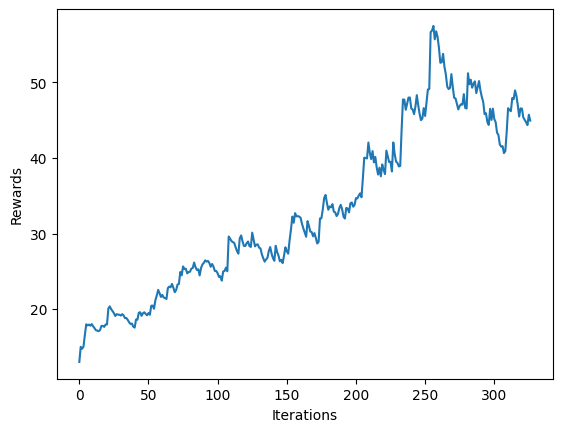

1/1 [==============================] - 0s 17ms/step


In [ ]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as
#        well (to re-initialize the model and optimizer)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            # initiate training - remember we don't know anything about how the
            #   agent is doing until it has crashed!
            g = train_step(cartpole_model, compute_loss, optimizer,
                       observations=np.vstack(memory.observations),
                       actions=np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))

            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

Pour avoir une idée de la façon dont notre agent s'est débrouillé, nous pouvons enregistrer une vidéo du modèle entraîné travaillant sur l'équilibre du poteau. Il s'agit d'un tout nouvel environnement que l'agent n'a jamais vu auparavant !

Affichons la vidéo enregistrée pour voir comment notre agent s'est comporté !

In [ ]:
matplotlib.use('Agg')
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v1")
mdl.lab3.play_video(saved_cartpole)

Quelles sont les performances de l'agent ? Pourriez-vous le former pendant une période plus courte tout en obtenant de bons résultats ? Pensez-vous qu'un entrainement plus long serait encore plus efficace ?